In [12]:
"""
!/usr/bin/env python
-*- coding: utf-8 -*-
@File:  inference.py
@Author: by Chen
@Date: 2025/9/28 16:00
@last Modified by: by Chen
@last Modified time: 2025/9/28 16:00
@Desc: 推理函数
"""
from my_dataset import MyDataset
import matplotlib.pyplot as plt 
import torch 
import torch.nn.functional as F
from clip import CLIP
from torchvision import transforms
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import math
from my_utils import plot_logits_matrix



正确分类: 0


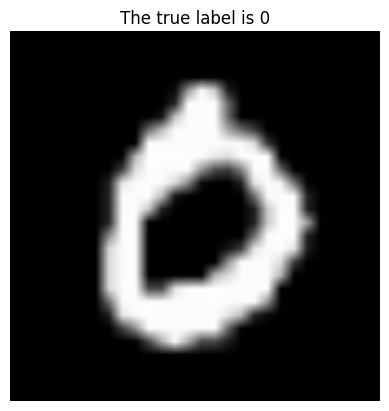

In [13]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

data_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.1307]*3, [0.3081]*3)
])

dataset = MyDataset(data_path='./mnist/', is_train=False, transform=data_transform)
# 1. 加载模型
model = CLIP().to(DEVICE)
model.load_state_dict(torch.load('./runs/best_model.pth', map_location=DEVICE))
model.eval()

# 2. 取一张图片
image, label = dataset[3]
print('正确分类:', label)

# 反归一化显示函数
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

image_show = denormalize(image.clone(), [0.1307]*3, [0.3081]*3)
plt.imshow(image_show.permute(1,2,0).cpu())
plt.axis('off')
plt.title('The true label is {}'.format(label))
plt.show()

In [14]:
model = CLIP().to(device=DEVICE)
model.load_state_dict(torch.load('./runs/best_model.pth'))

<All keys matched successfully>

In [15]:
model.eval()

CLIP(
  (img_enc): ImgEncoder(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)


In [16]:
# MNIST 数据集
dataset = torchvision.datasets.MNIST(root="./mnist", train=False, download=True)
labels = dataset.targets.tolist()
print("labels's shape is", len(labels))

labels's shape is 10000


In [17]:
import os
import random
from torchvision import transforms, utils

# 保存目录
save_dir = "inference_test"
# os.makedirs(save_dir, exist_ok=True)

# # 转 Tensor
# to_tensor = transforms.ToTensor()

# # 随机抽取 10 个索引
# indices = random.sample(range(len(dataset)), 10)

# # 保存图片
# for idx in indices:
#     img, label = dataset[idx]
#     if not isinstance(img, torch.Tensor):
#         img = to_tensor(img)
#     utils.save_image(img, os.path.join(save_dir, f"mnist_label_{label}_{idx}.png"))


In [18]:
# 设置targets，共十种分类
targets = torch.arange(0,10)
print("targets are ", targets)

targets are  tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [19]:
def show_saved_images_batch(model, save_dir="inference_test", data_transform=None, targets=None, device="cpu", num_images=10, batch_size=5):
    """
    批量显示保存的图片及预测结果，同时显示前10类的 logits。
    每行显示一批图片。
    
    Args:
        model: CLIP模型
        save_dir: 图片保存目录
        data_transform: 图片预处理
        targets: 文本类别向量
        device: 设备
        num_images: 总共显示的图片数量
        batch_size: 每批处理图片数量
    """
    # 获取图片列表
    image_files = sorted([f for f in os.listdir(save_dir) if f.endswith(".png")])[:num_images]
    n = len(image_files)

    # 批量处理
    images, labels = [], []
    for img_file in image_files:
        img_path = os.path.join(save_dir, img_file)
        img = Image.open(img_path)
        images.append(data_transform(img))
        try:
            label = img_file.split('_')[2].split('.')[0]
        except IndexError:
            label = "Unknown"
        labels.append(label)

    images_tensor = torch.stack(images).to(device)  # [N, C, H, W]
    logits = model(images_tensor, targets.to(device))  # [N, num_classes]
    probs = F.softmax(logits, dim=1)                       
    pred_labels = torch.argmax(probs, dim=1)
    pred_probs = torch.max(probs, dim=1)[0]

    # 显示图片及预测
    cols = batch_size
    rows = math.ceil(n / cols)
    plt.figure(figsize=(cols * 3, rows * 3))
    
    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].permute(1,2,0).cpu())
        plt.title(f"True: {labels[i]}\nPred: {pred_labels[i].item()}\nProb: {pred_probs[i].item():.5f}", fontsize=10)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

    plot_logits_matrix(logits.cpu().detach().numpy(), title="Logits Matrix", xticklabels=targets.cpu().numpy(), yticklabels=[f"Img {i}" for i in range(n)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8087585].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.7960303].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.42421296..2.8214867].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.

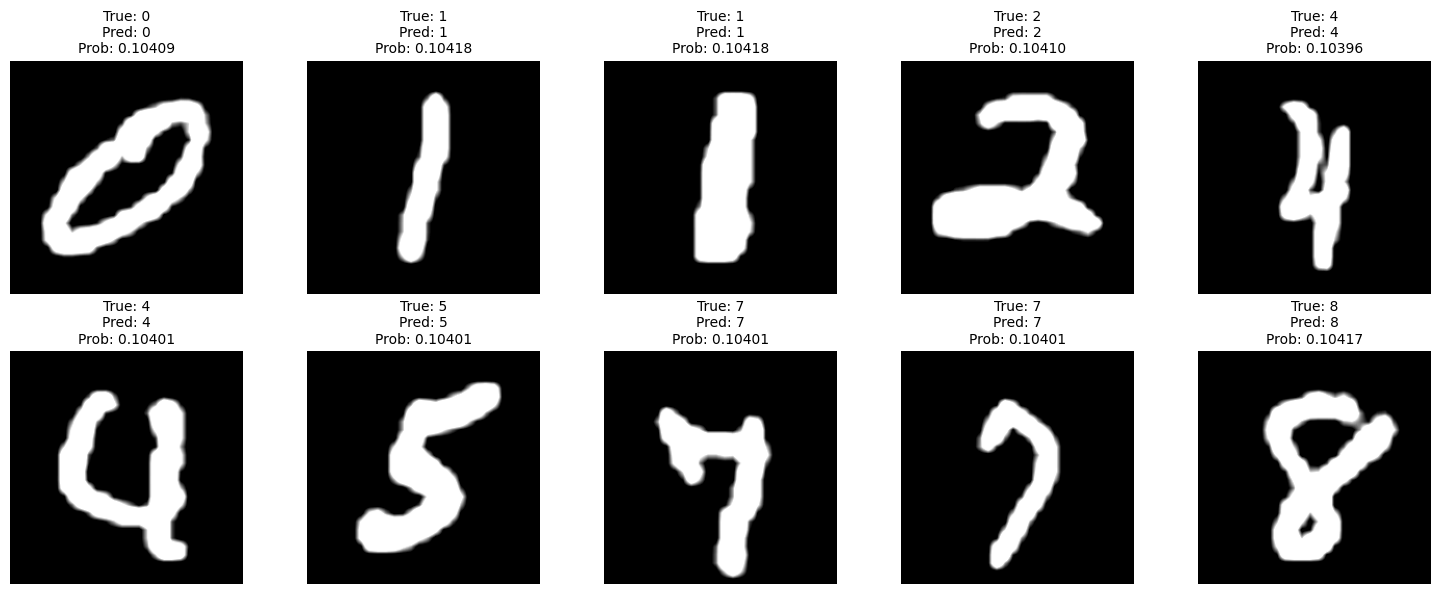

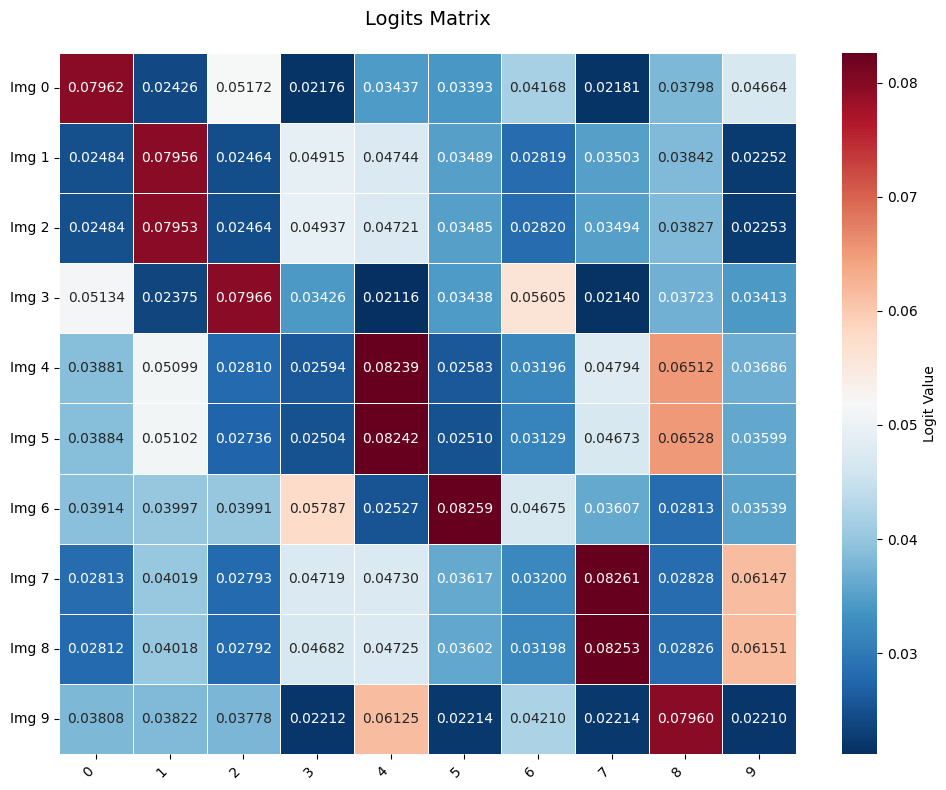

In [20]:
show_saved_images_batch(model, save_dir=save_dir, data_transform=data_transform, targets=targets, device=DEVICE, num_images=10)

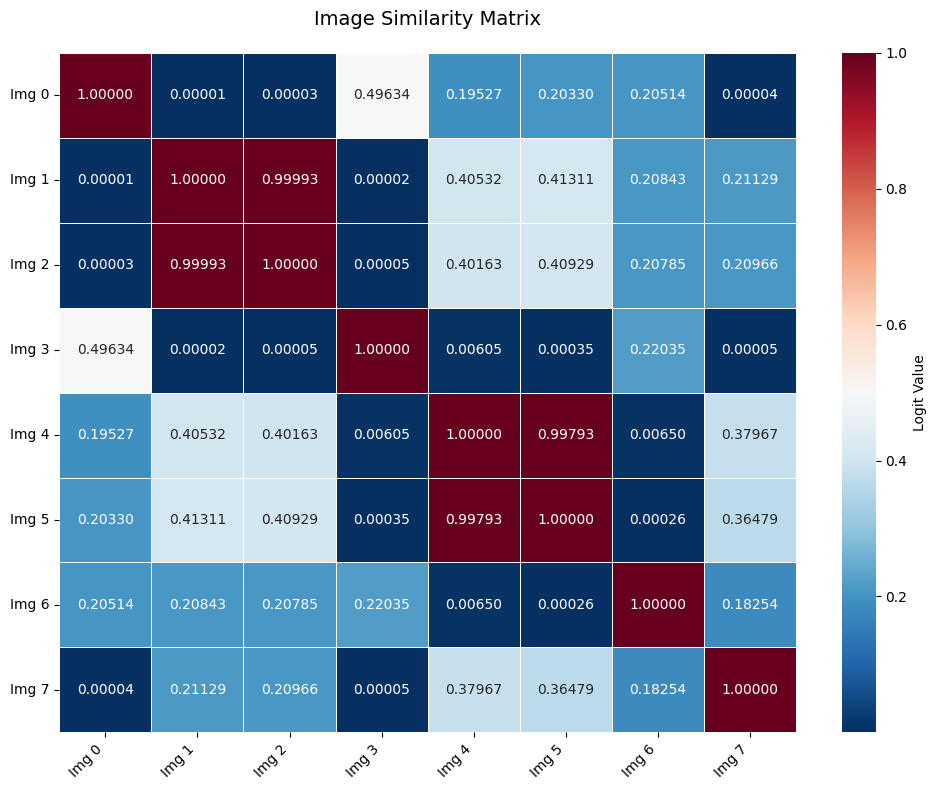

In [21]:
# 图像之间的相似度计算
def compute_image_similarities(model, images, device="cpu"):
    """
    计算图像之间的相似度矩阵。
    
    Args:
        model: CLIP模型
        images: 图像张量 [N, C, H, W]
        device: 设备
    Returns:
        sim_matrix: 相似度矩阵 [N, N]
    """
    model.eval()
    with torch.no_grad():
        images = images.to(device)
        image_features = model.img_enc(images)  # [N, D]
        image_features = image_features / image_features.norm(dim=1, keepdim=True)  # 归一化
        sim_matrix = image_features @ image_features.t()  # [N, N]
    return sim_matrix.cpu().numpy()

# 计算并显示相似度矩阵
image_files = sorted([f for f in os.listdir(save_dir) if f.endswith(".png")])[:8]
images = []
for img_file in image_files:
    img_path = os.path.join(save_dir, img_file)
    img = Image.open(img_path)
    images.append(data_transform(img))
images_tensor = torch.stack(images)  # [N, C, H, W]
sim_matrix = compute_image_similarities(model, images_tensor, device=DEVICE)
plot_logits_matrix(sim_matrix, title="Image Similarity Matrix", xticklabels=[f"Img {i}" for i in range(len(images))], yticklabels=[f"Img {i}" for i in range(len(images))])
